In [12]:
import requests
import statistics 
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib.style as style; style.use('fivethirtyeight')
from sympy import *
from scipy.integrate import odeint


In [13]:
url = 'https://api.covid19india.org/states_daily.json'
r1 = requests.get(url)
dictr1 = r1.json()
#print(dictr1)

In [14]:
df_india = pd.DataFrame(dictr1['states_daily'])
#df_india

In [15]:
df_india.columns

Index(['an', 'ap', 'ar', 'as', 'br', 'ch', 'ct', 'date', 'dateymd', 'dd', 'dl',
       'dn', 'ga', 'gj', 'hp', 'hr', 'jh', 'jk', 'ka', 'kl', 'la', 'ld', 'mh',
       'ml', 'mn', 'mp', 'mz', 'nl', 'or', 'pb', 'py', 'rj', 'sk', 'status',
       'tg', 'tn', 'tr', 'tt', 'un', 'up', 'ut', 'wb'],
      dtype='object')

In [16]:
N=1500000
#filterning data
df_goa=df_india[['date','status','ga']]
#df_goa
df_con=df_goa[df_goa['status']=='Confirmed'][['date','ga']]
df_con.columns=['date1','Confirmed']
#df_con
df_reco=df_goa[df_goa['status']=='Recovered'][['date','ga']]
df_reco.columns=['date2','Recovered']
#df_reco
df_dec=df_goa[df_goa['status']=='Deceased'][['date','ga']]
df_dec.columns=['date','Deceased']
#df_dec
df_goa_new=pd.concat([df_con.reset_index(drop=True),df_reco.reset_index(drop=True),df_dec.reset_index(drop=True)],axis=1)
df_goa_new=df_goa_new[['date','Confirmed','Recovered','Deceased']]

#converting to date time format
df_goa_new['Date'] = pd.to_datetime(df_goa_new['date'])

#converting to numeric data
df_goa_new['Confirmed'] = pd.to_numeric(df_goa_new['Confirmed'])
df_goa_new['Recovered'] = pd.to_numeric(df_goa_new['Recovered'])
df_goa_new['Deceased'] = pd.to_numeric(df_goa_new['Deceased'])
df_goa_new['Cumulative Confirmed'] = df_goa_new['Confirmed'].cumsum()
df_goa_new['Cumulative Recovered'] = df_goa_new['Recovered'].cumsum()
df_goa_new['Cumulative Deceased'] = df_goa_new['Deceased'].cumsum()

df_goa_new['currently infected']=df_goa_new['Cumulative Confirmed']-(df_goa_new['Cumulative Recovered']+df_goa_new['Cumulative Deceased'])
df_goa_new['S_t']=N-(df_goa_new['currently infected']+df_goa_new['Cumulative Recovered']+df_goa_new['Cumulative Deceased'])
df_goa_new['s_t']=(df_goa_new['S_t']/N)
df_goa_new['s_tminus1'] =df_goa_new['s_t'].shift(1)
df_goa_new['I_tminus1'] = df_goa_new['currently infected'].shift(1)
df_goa_new['c_ij_1']=(df_goa_new['s_tminus1'] *df_goa_new['I_tminus1'])
df_goa_new['R_t'] = df_goa_new['Cumulative Recovered']+df_goa_new['Cumulative Deceased']
df_goa_new['R_tminus1'] = df_goa_new['R_t'].shift(1)
df_goa_new['u_j']=df_goa_new['currently infected']-df_goa_new['I_tminus1']
df_goa_new['v_j']=df_goa_new['R_t']-df_goa_new['R_tminus1']

In [17]:
def LA_method(df):
    list_c_j_1=df['c_ij_1'].tolist()
    list_I_jminus1=df['I_tminus1'].tolist()
    list_u_j=df['u_j'].tolist()
    list_v_j=df['v_j'].tolist()
    
    #converting to matrix
    matrix_c_j_1=Matrix(list_c_j_1)
    matrix_I_jminus1=Matrix(list_I_jminus1)
    matrix__u_j=Matrix(list_u_j)
    matrix__v_j=Matrix(list_v_j)
    matrix_c_j_2=matrix_I_jminus1*(-1)
    
    rows=len(list_I_jminus1)
    zero_matrix = zeros(rows, 1)
    C=matrix_c_j_1.row_join(matrix_c_j_2)
    D=zero_matrix.row_join(matrix_I_jminus1)
    w=matrix__u_j.col_join(matrix__v_j)
    A=C.col_join(D)
    X=A.T*(A)
    X_inv=X.inv()
    s=X_inv*A.T
    
    y=s*w
    print(y)
    
    
    b=y[0,0]
    k=y[1,0]
    print('b',b)
    print('k',k)

    #R0 denotes ratio b/k
    R0=b/k
    print('R0',R0)
    return b,k


In [18]:
def finding_SIR_values(df):    
    currently_infected_list=df['currently infected'].tolist()
    S_t_list=df['S_t'].tolist()
    cumulative_recovered_list=df['Cumulative Recovered'].tolist()
    cumulative_deceased_list=df['Cumulative Deceased'].tolist()

    #calculating S0, I0, R0, here R0 denotes total number of recovered people at t=0
    I_naught=currently_infected_list[0]
    R_naught=cumulative_recovered_list[0]+cumulative_deceased_list[0]
    S_naught=N-I_naught-R_naught
    print(S_naught,I_naught,R_naught)


    
        
    return S_naught, I_naught, R_naught    
    #print(days)

In [19]:
# starting_dates=['2020-05-28','2020-07-01','2020-08-01']
# ending_dates=['2020-07-07','2020-08-07','2020-10-19']

starting_dates=['2020-03-28']
ending_dates=['2020-07-20']
df_temp=df_goa_new
list_S_naught=[]
list_I_naught=[]
list_R_naught=[]
list_b=[]
list_k=[]
phases=[]
phase=0
for i,j in zip(starting_dates,ending_dates):
    phase=phase+1
    print('Start date=',i,'and End date=',j)
    
    df_n=df_goa_new[df_goa_new['Date']>=i]
    df_new=df_n[df_n['Date']<=j]
    df_new=df_new.reset_index(drop=True)
    df_goa_new=df_new
    b,k=LA_method(df_goa_new)
    
    list_b.append(b)
    list_k.append(k)
    
    S_naught, I_naught, R_naught=finding_SIR_values(df_goa_new)
    
    list_S_naught.append(S_naught)
    list_R_naught.append(R_naught)
    list_I_naught.append(R_naught)
    phases.append(phase)
    df_goa_new=df_temp
    

Start date= 2020-03-28 and End date= 2020-07-20
Matrix([[0.118409587083075], [0.0809242877947152]])
b 0.118409587083075
k 0.0809242877947152
R0 1.46321444784848
1499997 3 0


In [20]:
df_goa_new

,date,Confirmed,Recovered,Deceased,Date,Cumulative Confirmed,Cumulative Recovered,Cumulative Deceased,currently infected,S_t,s_t,s_tminus1,I_tminus1,c_ij_1,R_t,R_tminus1,u_j,v_j
0,14-Mar-20,0,0,0,2020-03-14,0,0,0,0,1500000,1.000000,NaN,NaN,NaN,0,NaN,NaN,NaN
1,15-Mar-20,0,0,0,2020-03-15,0,0,0,0,1500000,1.000000,1.000000,0.0,0.000000,0,0.0,0.0,0.0
2,16-Mar-20,0,0,0,2020-03-16,0,0,0,0,1500000,1.000000,1.000000,0.0,0.000000,0,0.0,0.0,0.0
3,17-Mar-20,0,0,0,2020-03-17,0,0,0,0,1500000,1.000000,1.000000,0.0,0.000000,0,0.0,0.0,0.0
4,18-Mar-20,0,0,0,2020-03-18,0,0,0,0,1500000,1.000000,1.000000,0.0,0.000000,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,01-Nov-20,142,237,5,2020-11-01,43768,40915,609,2244,1456232,0.970821,0.970916,2344.0,2275.827104,41524,41282.0,-100.0,242.0
233,02-Nov-20,186,208,7,2020-11-02,43954,41123,616,2215,1456046,0.970697,0.970821,2244.0,2178.523072,41739,41524.0,-29.0,215.0
234,03-Nov-20,235,239,2,2020-11-03,44189,41362,618,2209,1455811,0.970541,0.970697,2215.0,2150.094593,41980,41739.0,-6.0,241.0
235,04-Nov-20,183,249,8,2020-11-04,44372,41611,626,2135,1455628,0.970419,0.970541,2209.0,2143.924333,42237,41980.0,-74.0,257.0


In [21]:
currently_infected_list=df_goa_new['currently infected'].tolist()
days=[]
for i in range(len(currently_infected_list)):
    days.append(i+1)
def deriv(y, t, N, beta, gamma):
        S, I, R = y
        dSdt = -beta * S * I / N
        dIdt = beta * S * I / N - gamma * I
        dRdt = gamma * I
        return dSdt, dIdt, dRdt    
#diff equation
#print(days.count())
list_S=[]
list_I=[]
list_R=[]
t=np.linspace(0,400,200)

for i in range(len(phases)):
    #t=np.linspace(0,300,200)
    beta=list_b[i]
    gamma=list_k[i]
    
    y0 = S_naught, I_naught, R_naught

    ret = odeint(deriv, y0, t, args=(N, beta, gamma))
    S, I, R = ret.T
    #print(I)
    list_S.append(S)
    list_I.append(I)
    list_R.append(R)
    
    if i==0:
        I_1=I
    if i==1:
        I_2=I
    if i==2:
        I_3=I
#print(list_I)

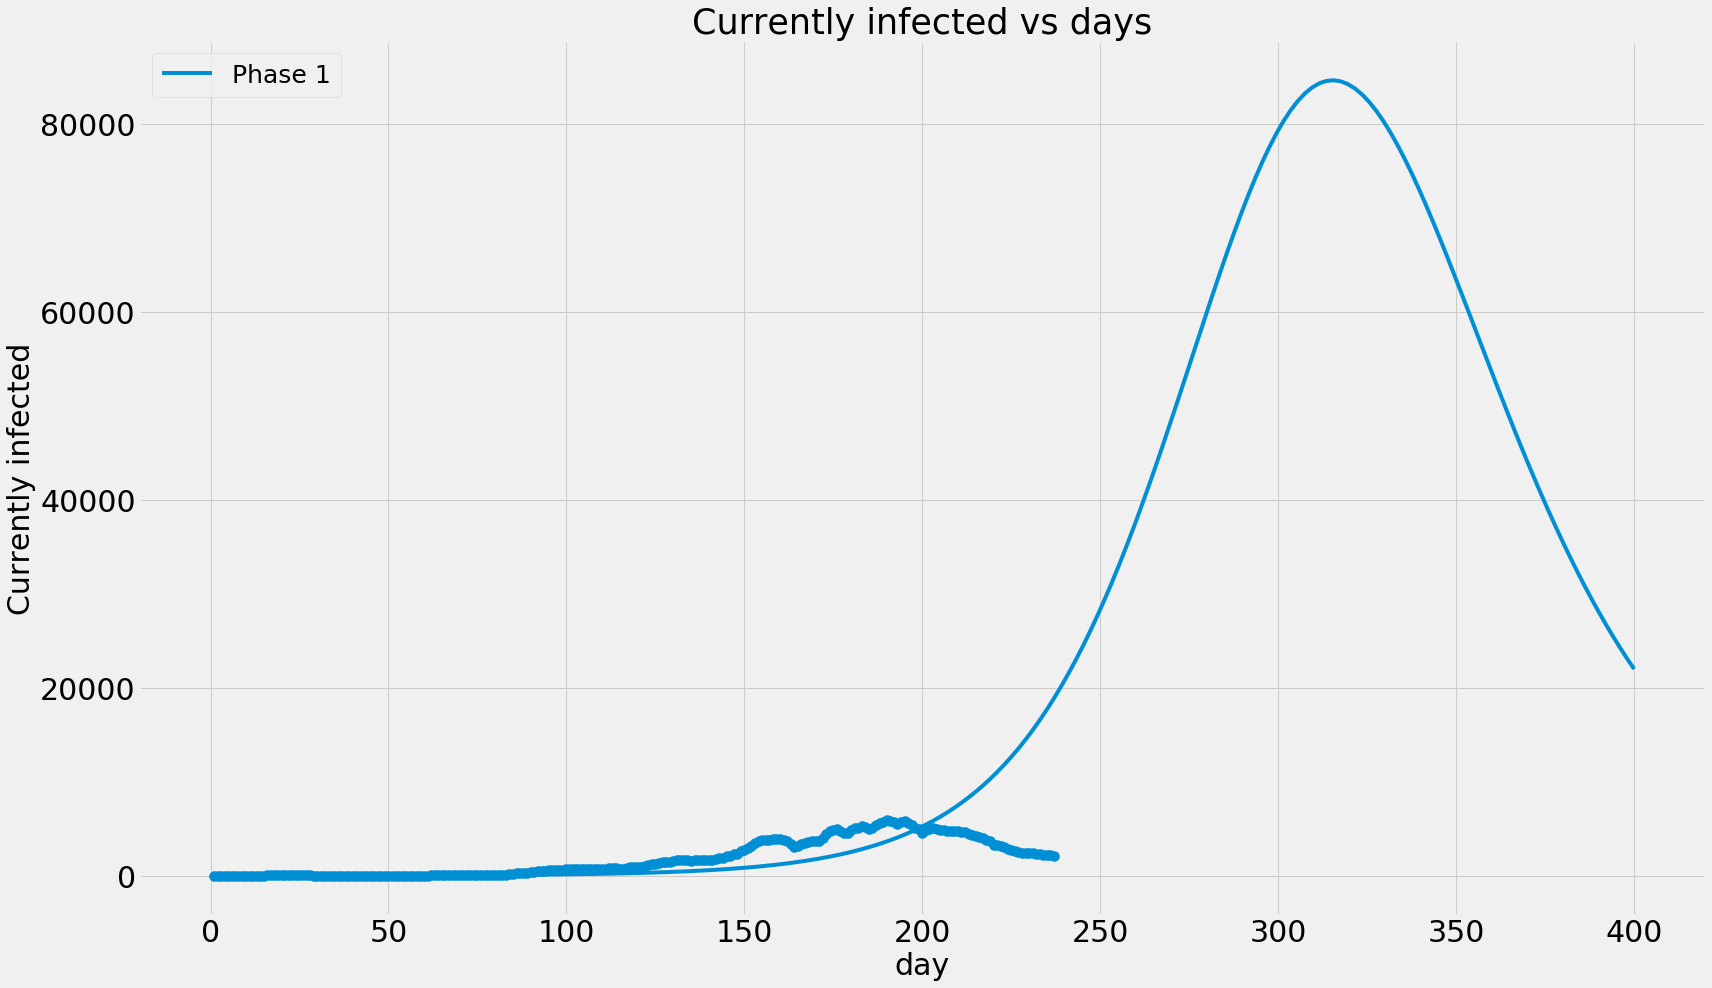

In [22]:
#plotting graph
plt.figure(figsize= (25,15))
plt.scatter(days, currently_infected_list, s=100)
plt.plot(t,I_1, label="Phase 1")
# plt.plot(t,I_2, label="Phase 2")
#plt.plot(t,I_3, label="Phase 3")
plt.rc('xtick', labelsize=30) 
plt.rc('ytick', labelsize=30) 
plt.title("Currently infected vs days", fontsize=35)
plt.ylabel("Currently infected", fontsize=30)
plt.xlabel("day",fontsize=30)
plt.legend(prop={'size': 25},loc='upper left')
plt.show()